## Welcome to the `deeplabv3_plus_starter` Workshop!

In this workshop, we'll learn about building blocks of Deeplabv3+ architecture. 
Building blocks of Deeplabv3+ architecture:
1. **Atrous / Dilated Convolutions**. It is the core of Deeplab-based models. It `increases the FOV of encoder` without increasing number of parameters
2. **Atrous Spatial Pyramid Pooling** - Similar to PSPNet, captures Multi-scale features to identify objects of different scales, but using Atrous convolutions
3. **Encoder-Decoder architecture** - Inspired from UNet architecture
4. **Average Pooling**  to get a Global Context Prior

We'll cover these concepts in this notebook

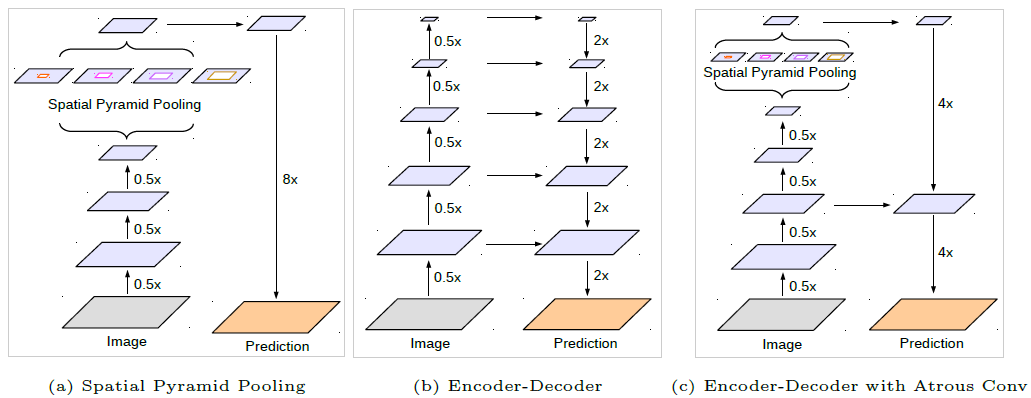

[Image reference](https://arxiv.org/pdf/1802.02611.pdf)

In [2]:
# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

## Atrous Spatial Pyramid Convolution Module

It is a **normal Conv-BatchNorm-Relu module but with dilation applied**. The output size remains the same between a normal and an Atrous convolution module. But the filter takes in wider set of inputs for dilation > 1

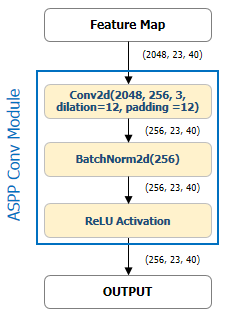

In [3]:
class aspp_conv(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rate):
        super(aspp_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, dilation=dilation_rate, padding=dilation_rate, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
        
    def forward(self, x):
        return self.conv(x)

In [4]:
## Test with sample inputs
aspp_conv_test_input = torch.Tensor(2, 2048, 23, 40)
model = aspp_conv(in_channels=2048, out_channels=256, dilation_rate=6)
aspp_conv_test_output = model(aspp_conv_test_input)
print("aspp_conv_test_input.shape", aspp_conv_test_input.shape)
print("aspp_conv_test_output.shape", aspp_conv_test_output.shape)

aspp_conv_test_input.shape torch.Size([2, 2048, 23, 40])
aspp_conv_test_output.shape torch.Size([2, 256, 23, 40])


## Average Pooling Module

It is a simple Average pooling module which condenses input feature map spatially before upsampling to input size

In [5]:
class aspp_pool(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(aspp_pool, self).__init__()
        self.pooling_module = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
        
    def forward(self, x):
        input_size = x.shape[-2:]
        x = self.pooling_module(x)
        return F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)

## Atrous Spatial Pyramid Pooling Module

- ASPP module takes input feature map from backbone 
- Passes input through ASPP_conv modules of different dilation rates to capture multi scale features
- Average pooling module to get global context prior
- Skip-connection to get image-level features
- **Output from ASPP module is generally OS = 16 / OS = 8**

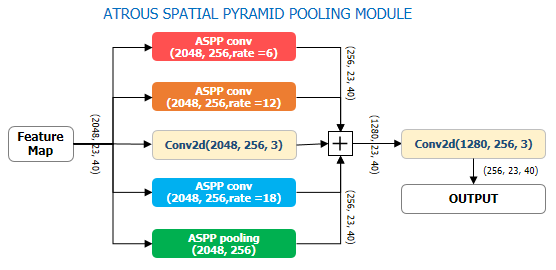

In [6]:
class atrous_spatial_pyramid_pooling(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rates):
        super(atrous_spatial_pyramid_pooling, self).__init__()

        layers = nn.ModuleList([])
        
        # skip-connection, match the output channels
        # using 1x1 convolutions
        layers.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ))
        
        # spatial pyramid pooling wiht atrous convolutions
        for rate in dilation_rates:
            layers.append(aspp_conv(in_channels, out_channels, rate))
            
        # image pooling layer
        layers.append(aspp_pool(in_channels, out_channels))
        
        # create Pytorch module list
        self.layers = nn.ModuleList(layers)
        
        # 1x1 convolution to project concatenated output
        # to desired number of channels
        self.project = nn.Sequential(
            nn.Conv2d(len(layers) * out_channels, out_channels, kernel_size=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
    
    def forward(self, x):
        conv_outputs = []
        for mod in self.layers:
            mod_output = mod(x)
            conv_outputs.append(mod_output)
        
        # concatenate output and reduce num_channels
        output = self.project(torch.cat(conv_outputs, dim=1))
        return output        

In [7]:
# test module with sample input
aspp_module_test_input = torch.Tensor(2, 2048, 23, 40)
aspp_module = atrous_spatial_pyramid_pooling(2048, 
                       out_channels=256, dilation_rates=[6, 12, 18])
aspp_module_test_output = model(aspp_module_test_input)

# print result
print("aspp_module_test_input.shape", aspp_module_test_input.shape)
print("aspp_module_test_output.shape", aspp_module_test_output.shape)

aspp_module_test_input.shape torch.Size([2, 2048, 23, 40])
aspp_module_test_output.shape torch.Size([2, 256, 23, 40])


## Deeplabv3+ Decoder

- **Decoder Module is the primary difference between deeplabv3 and deeplabv3+**
- Authors propose that using low level feature map from backbone in the *decoder renea the segmentation results especially along object boundaries*

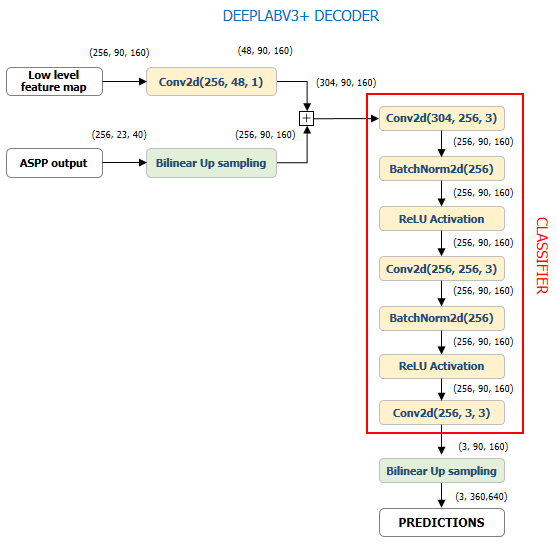

In [8]:
class deeplabv3_decoder(nn.Module):
    def __init__(self, num_classes):
        super(deeplabv3_decoder, self).__init__()
        self.num_classes = num_classes
        
        # resnet low level features contain 256 channels
        self.low_level_project = nn.Sequential(
            nn.Conv2d(256, 48, kernel_size=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU())
        
        # classifier head
        self.cls = nn.Sequential(
            nn.Conv2d(304, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(),            
            nn.Conv2d(256, self.num_classes, kernel_size=1))
                     
        
    def forward(self, x, low_level_feat):
        # projected_low_level_feat = (48, h//4, w//4)
        low_level_feat = self.low_level_project(low_level_feat)

        # x = (256, h//4, w//4)
        x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=False)
        
        # x = (256 + 48, h//4, w//4)
        x = torch.cat((x, low_level_feat), dim=1)
        
        # x = (num_classes, h//4, w//4)
        x = self.cls(x)
        return x

In [9]:
# test module with sample input
decoder_aspp_input = torch.Tensor(2, 256, 23, 40)
decoder_low_level_input = torch.Tensor(2, 256, 90, 360)

decoder_module = deeplabv3_decoder(num_classes=3)
decoder_test_output = decoder_module(decoder_aspp_input, decoder_low_level_input)

# print result
print("decoder_aspp_input.shape", decoder_aspp_input.shape)
print("decoder_low_level_input.shape", decoder_low_level_input.shape)
print("decoder_test_output.shape", decoder_test_output.shape)

decoder_aspp_input.shape torch.Size([2, 256, 23, 40])
decoder_low_level_input.shape torch.Size([2, 256, 90, 360])
decoder_test_output.shape torch.Size([2, 3, 90, 360])


## Points to Note

1. In the **original Deeplabv3+ paper, authors use Resnet101 and Aligned Xception models as backbone** and compare results
2. Aligned Xception model uses **Depthwise Separable convolution**. Authors modify it using Dilation to create **Atrous Separable convolution** 

## Useful references for Deeplab models
- [Deeplabv3+ arXiv paper](https://arxiv.org/pdf/1802.02611)
- [Deeplabv3 arXiv paper](https://arxiv.org/abs/1706.05587)
- [deeplabv3+ pytorch](https://github.com/VainF/DeepLabV3Plus-Pytorch)
- [pytorch-deeplab-xception](https://github.com/jfzhang95/pytorch-deeplab-xception)
- [deeplabv3 impl](https://github.com/fregu856/deeplabv3)